In [1]:
!pip install cenpy
!pip install python-Levenshtein
!pip install contextily
!pip install geopandas==0.9
!pip install rtree

     |████████████████████████████████| 994 kB 6.2 MB/s eta 0:00:01


  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.8.2
    Uninstalling geopandas-0.8.2:
      Successfully uninstalled geopandas-0.8.2


# Extracting data for Alameda County, California

This dataset contains an extract of a set of variables from the 2017 ACS Census Tracts for the Oakland City (CA) 

In [33]:
import contextily
import geopandas
import cenpy

acs = cenpy.products.ACS(2017)

## CENPY Documentation: 
https://cenpy-devs.github.io/cenpy/


## Download Data

- Set variables to download

In [4]:
vars_to_download = {
    "B02001_002E": "total_pop_white",     # Total white population
    "B02001_003E": "total_pop_black",     #Total black population
    "B01003_001E": "total_pop",           # Total population
    "B09019_001E": "hh_total",            # Total households
    "B15003_022E": "total_bachelor",      # Total w/ Bachelor degree B06009_005E
    "B01002_001E": "median_age",          # Median age
    "B19013_001E": "median_hh_income",     # Median household income 
    "B19058_001E": "SNAP_hh",              # Households receiving Food Stamps/SNAP 
    "B08015_001E": "access_to_vehicle",     # Workers over age 16 that drove alone to work by car, van, truck
    "B02001_005E": "total_pop_asian",      # Total asian population
    "B02001_007E": "total_other_race",      # Total other race population
    "B01001I_001E": "total_hispanic",       # Total hispanic population     
}
vars_to_download_l = list(vars_to_download.keys())

In [6]:
db=[]

source for other variable names: https://api.census.gov/data/2017/acs/acs5/variables.html

- Download geometries and attributes (***this can take sometime***)

In [20]:
%%time
db = acs.from_county("Alameda, CA",
                  level="tract",
                  variables=vars_to_download_l)

/Users/marta/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 1.28 s, sys: 36.1 ms, total: 1.32 s
Wall time: 16.5 s


In [21]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         361 non-null    object  
 1   geometry      361 non-null    geometry
 2   B01001I_001E  361 non-null    float64 
 3   B01002_001E   360 non-null    float64 
 4   B01003_001E   361 non-null    float64 
 5   B02001_002E   361 non-null    float64 
 6   B02001_003E   361 non-null    float64 
 7   B02001_005E   361 non-null    float64 
 8   B02001_007E   361 non-null    float64 
 9   B08015_001E   357 non-null    float64 
 10  B09019_001E   361 non-null    float64 
 11  B15003_022E   361 non-null    float64 
 12  B19013_001E   360 non-null    float64 
 13  B19058_001E   361 non-null    float64 
 14  NAME          361 non-null    object  
 15  state         361 non-null    object  
 16  county        361 non-null    object  
 17  tract         361 non-null    object  
dtypes:

In [22]:
db.head()

,GEOID,geometry,B01001I_001E,B01002_001E,B01003_001E,B02001_002E,B02001_003E,B02001_005E,B02001_007E,B08015_001E,B09019_001E,B15003_022E,B19013_001E,B19058_001E,NAME,state,county,tract
0,06001441524,"POLYGON ((-13587578.570 4518775.620, -13587550...",197.0,36.3,4432.0,559.0,79.0,3644.0,22.0,1225.0,4432.0,973.0,146250.0,1399.0,"Census Tract 4415.24, Alameda County, California",06,001,441524
1,06001444100,"POLYGON ((-13586775.400 4516294.100, -13586758...",2251.0,43.4,7752.0,3848.0,76.0,2125.0,1007.0,2625.0,7752.0,1553.0,111467.0,2504.0,"Census Tract 4441, Alameda County, California",06,001,444100
2,06001441302,"POLYGON ((-13584576.390 4518985.030, -13584553...",862.0,38.6,5881.0,1808.0,166.0,2982.0,449.0,1830.0,5881.0,1411.0,115673.0,1849.0,"Census Tract 4413.02, Alameda County, California",06,001,441302
3,06001440335,"POLYGON ((-13583367.570 4521290.320, -13583346...",639.0,35.0,6979.0,1311.0,275.0,4326.0,590.0,1605.0,6979.0,1612.0,137265.0,2221.0,"Census Tract 4403.35, Alameda County, California",06,001,440335
4,06001441200,"POLYGON ((-13581697.670 4520696.960, -13581688...",1458.0,37.7,6977.0,3228.0,177.0,2410.0,605.0,2120.0,6977.0,1467.0,120658.0,2456.0,"Census Tract 4412, Alameda County, California",06,001,441200


## Metadata

We will also write a companion file with the names of each variable:

In [23]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)

In [24]:
var_names

,var_id,label,concept,short_name
0,B02001_002E,Estimate!!Total!!White alone,RACE,total_pop_white
1,B02001_003E,Estimate!!Total!!Black or African American alone,RACE,total_pop_black
2,B01003_001E,Estimate!!Total,TOTAL POPULATION,total_pop
3,B09019_001E,Estimate!!Total,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY REL...,hh_total
4,B15003_022E,Estimate!!Total!!Bachelor's degree,EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 Y...,total_bachelor
5,B01002_001E,Estimate!!Median age --!!Total,MEDIAN AGE BY SEX,median_age
6,B19013_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,median_hh_income
7,B19058_001E,Estimate!!Total,PUBLIC ASSISTANCE INCOME OR FOOD STAMPS/SNAP I...,SNAP_hh
8,B08015_001E,"Estimate!!Aggregate number of vehicles (car, t...","AGGREGATE NUMBER OF VEHICLES (CAR, TRUCK, OR V...",access_to_vehicle
9,B02001_005E,Estimate!!Total!!Asian alone,RACE,total_pop_asian


## Process data

While the ACS comes with a large number of attributes, we are not limited to the original variables at hand; we
can construct additional variables. This is particularly useful when
we want to compare areas that are not very similar in some structural
characteristic, such as area or population. For example, a quick look into the
variable names shows most variables are counts. For tracts of different sizes,
these variables will mainly reflect their overall population, rather than provide direct information
about the variables itself. To get around this, we will cast many of these count variables to rates,
and use them in addition to a subset of the original variables. 

- Replace missing values with columns mean

In [25]:
vars_to_download

{'B02001_002E': 'total_pop_white',
 'B02001_003E': 'total_pop_black',
 'B01003_001E': 'total_pop',
 'B09019_001E': 'hh_total',
 'B15003_022E': 'total_bachelor',
 'B01002_001E': 'median_age',
 'B19013_001E': 'median_hh_income',
 'B19058_001E': 'SNAP_hh',
 'B08015_001E': 'access_to_vehicle',
 'B02001_005E': 'total_pop_asian',
 'B02001_007E': 'total_other_race',
 'B01001I_001E': 'total_hispanic'}

In [26]:
filler = lambda col: col.fillna(col.mean())
db.loc[:, vars_to_download] = db.loc[:, vars_to_download]\
                                .apply(filler)

In [27]:
db = db.rename(columns=vars_to_download)  #rename columns

In [28]:
db.head()

,GEOID,geometry,total_hispanic,median_age,total_pop,total_pop_white,total_pop_black,total_pop_asian,total_other_race,access_to_vehicle,hh_total,total_bachelor,median_hh_income,SNAP_hh,NAME,state,county,tract
0,06001441524,"POLYGON ((-13587578.570 4518775.620, -13587550...",197.0,36.3,4432.0,559.0,79.0,3644.0,22.0,1225.0,4432.0,973.0,146250.0,1399.0,"Census Tract 4415.24, Alameda County, California",06,001,441524
1,06001444100,"POLYGON ((-13586775.400 4516294.100, -13586758...",2251.0,43.4,7752.0,3848.0,76.0,2125.0,1007.0,2625.0,7752.0,1553.0,111467.0,2504.0,"Census Tract 4441, Alameda County, California",06,001,444100
2,06001441302,"POLYGON ((-13584576.390 4518985.030, -13584553...",862.0,38.6,5881.0,1808.0,166.0,2982.0,449.0,1830.0,5881.0,1411.0,115673.0,1849.0,"Census Tract 4413.02, Alameda County, California",06,001,441302
3,06001440335,"POLYGON ((-13583367.570 4521290.320, -13583346...",639.0,35.0,6979.0,1311.0,275.0,4326.0,590.0,1605.0,6979.0,1612.0,137265.0,2221.0,"Census Tract 4403.35, Alameda County, California",06,001,440335
4,06001441200,"POLYGON ((-13581697.670 4520696.960, -13581688...",1458.0,37.7,6977.0,3228.0,177.0,2410.0,605.0,2120.0,6977.0,1467.0,120658.0,2456.0,"Census Tract 4412, Alameda County, California",06,001,441200


- Map the region

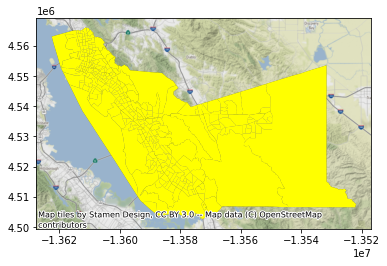

In [29]:
ax = db.plot(alpha=0.5, color="k")
db.plot(ax=ax, color="yellow")
contextily.add_basemap(ax,crs=db.crs);

## Use the code of sandiego_tracts_cleaning.ipynb to add relevant columns to your data sets. Examples are:

New Data Columns: 
- pct_white           
#Fraction of White Population per Track (total_pop_white/total_pop)
- pct_black         
#Fraction of Black Population per Track (total_pop_black/total_pop)
- pct_bachelor        
#Fraction of Population with Bachelors degree per Track (total_bachelor/total_pop) 
- pct_hispanic  
#Fraction of Hispanic Population per Track (total_hispanic/total_pop)
- veh_per_pop         
#Ratio of Workers with Access to Vehicle per Population (access_to_vehicle/total_pop)
- pct_SNAP_hh     
#Households receiving Food Stamps/SNAP (access_to_vehicle/hh_total) 

## Export the data as a shapefile: alameda_tracts.gpkg (sandiego_tracts_cleaning.ipynb) to answer the questions of Part 2


### Part 2-  Q1: Select 6 relevant census variables to do K-means clustering, and justify their selection (20 pts)

### Part 2- Q2: Present the result of K-means clustering with three clusters (k=3) and five clusters (k=5),  show in each case the distributions of each cluster and the maps (50 pts)

### Part 2- Q3: In each of the two clustering results, what cluster group the vulnerable population in term of food stamp needs and no access to vehicles? (30 pts)